# Full gender classification run with Convolutional Neural Network #

Taking raw images that have been labeled for us already in folders, and then feeding them through a convolutional neural network for classification. 


# Part 1 - Preprocessing

Raw images can't exactly just stuff right through the convolutional neural network. So the dataset has to be preprocced first as :

    -> All of the images to be the same size, and probably wanted to be just grayscaled.
    
    -> Also, the labels of "female" and "male" are not useful, so want them to be one-hot arrays. 


<h4>Package Requirements</h4>

numpy (pip install numpy)

tqdm (pip install tqdm)

Tensorflow 

tflearn

First, we'll get our imports and constants for preprocessing:

In [2]:
import cv2                 # 4 resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
import glob

# Train and test dataset directories
TRAIN_DIR = '/home/mele/datasets/gender/train'
TEST_DIR = '/home/mele/datasets/gender/test'

# TRAIN_DIR = 'Image_dataset/train'
# TEST_DIR = 'Image_dataset/test'

IMG_SIZE = 50
LR = 1e-3 # learning rate

MODEL_NAME = 'gender_classification.model' # just so we remember which saved model is which, sizes must match

Now, convert the images and labels to array information sothat it can be easy to go through our network. 

Helper functions are below


In [3]:
# Image names are like 'gender/train/f/... .jpg or 'gender/train/m/... .jpg
 
def label_img(img_name):
    word_label = '/f/' in img_name
    
    # conversion to one-hot array [female,male]
    
    if word_label:      # [female, 0]
        return [1,0]
    
    else:               # [0, male]
        return [0,1]

Now, we can build another function to fully process the training images and their labels into arrays:

In [4]:
def create_train_data():
    training_data = []
    classes = ['f', 'm']
    
    for gender_fields in classes:   
        path = os.path.join(TRAIN_DIR, gender_fields, '*.jpg')
    
        files = glob.glob(path)
        
        for img in files[:12500]: # 25000 files in train_data finally
            label = label_img(img)
            img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            training_data.append([np.array(img),np.array(label)])
        shuffle(training_data)
    
    np.save('Image_dataset/gender_train_data.npy', training_data)
    
    return training_data

In [5]:
def process_test_data():
    testing_data = []
    classes = ['f', 'm']
    
    for gender_fields in classes:   
        path = os.path.join(TEST_DIR, gender_fields, '*.jpg')
    
        files = glob.glob(path)
        
        for img in files[:2500]: # 5000 files for test
            label = label_img(img)
            img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            testing_data.append([np.array(img),np.array(label)])
        shuffle(testing_data)
    
    np.save('Image_dataset/gender_test_data.npy', testing_data)
    
    return testing_data

Now, we can run the training:

In [6]:
# train_data = create_train_data()
train_data = np.load('Image_dataset/gender_train_data.npy') # If you have already created the dataset

print(len(train_data))

25000


# Convolutional Neural Network

Next, we're ready to define our neural network:

In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

conv_input = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet_1 = conv_2d(conv_input, 32, 5, activation='relu')
convnet_layer1 = max_pool_2d(convnet_1, 5)

convnet_2 = conv_2d(convnet_layer1, 64, 5, activation='relu')
convnet_layer2 = max_pool_2d(convnet_2, 5)

convnet_3 = fully_connected(convnet_layer2, 1024, activation='relu')
convnet_full = dropout(convnet_3, 0.8)

convnet_4 = fully_connected(convnet_full, 2, activation='softmax')

convnet_out = regression(convnet_4, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
model = tflearn.DNN(convnet_out, tensorboard_dir='log')

What we have here is a nice, 2 layered convolutional neural network, with a fully connected layer, and then the output layer. 

With this convnet let's see how it does with gender images at 50x50 resolution. 

Save the model after every session, and reloading it if it has a saved version

In [9]:

if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print(MODEL_NAME)

Now, let's split out training and validation:

In [10]:
train = train_data[:-1000] # 24000 datas for traing the model
valid = train_data[-1000:] #1000 data for validation

Now, the training data and validation data are both labeled datasets.
Next, we're going to create our data arrays.

In [11]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

valid_x = np.array([i[0] for i in valid]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
valid_y = [i[1] for i in valid]

Now we fit for 3 epochs:

In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': valid_x}, {'targets': valid_y}), 
    snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

Training Step: 1124  | total loss: 11.35819 | time: 76.741s
| Adam | epoch: 003 | loss: 11.35819 - acc: 0.5067 -- iter: 23936/24000
Training Step: 1125  | total loss: 11.37367 | time: 77.962s
| Adam | epoch: 003 | loss: 11.37367 - acc: 0.5060 | val_loss: 11.67411 - val_acc: 0.4930 -- iter: 24000/24000
--


## A bigger network , (more layers)


In [13]:
import tensorflow as tf
tf.reset_default_graph()

In [14]:
convnet_input = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet_1 = conv_2d(convnet_input, 32, 5, activation='relu')
convnet_layer1 = max_pool_2d(convnet_1, 5)

convnet_2 = conv_2d(convnet_layer1, 64, 5, activation='relu')
convnet_layer2 = max_pool_2d(convnet_2, 5)

convnet_3 = conv_2d(convnet_layer2, 128, 5, activation='relu')
convnet_layer3 = max_pool_2d(convnet_3, 5)

convnet_4 = conv_2d(convnet_layer3, 64, 5, activation='relu')
convnet_layer4 = max_pool_2d(convnet_4, 5)

convnet_5 = conv_2d(convnet_layer4, 32, 5, activation='relu')
convnet_layer5 = max_pool_2d(convnet_5, 5)

convnet_full_1 = fully_connected(convnet_layer5, 1024, activation='relu')
convnet_full_1_out = dropout(convnet_full_1, 0.8)

convnet_full_2 = fully_connected(convnet_full_1_out, 2, activation='softmax')
convnet_out = regression(convnet_full_2, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')


In [15]:
model = tflearn.DNN(convnet_out, tensorboard_dir='log')

In [16]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [17]:
train = train_data[:-1000]
valid = train_data[-1000:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

valid_x = np.array([i[0] for i in valid]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
valid_y = [i[1] for i in valid]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': valid_x}, {'targets': valid_y}), 
    snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

Training Step: 1124  | total loss: 0.69302 | time: 90.867s
| Adam | epoch: 003 | loss: 0.69302 - acc: 0.5168 -- iter: 23936/24000
Training Step: 1125  | total loss: 0.69308 | time: 92.366s
| Adam | epoch: 003 | loss: 0.69308 - acc: 0.5120 | val_loss: 0.69308 - val_acc: 0.5070 -- iter: 24000/24000
--


With neural networks, size matters a ton. 

Save it.

In [18]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/mele/PycharmProjects/gender_classification_convnet/gender_classification.model is not in all_model_checkpoint_paths. Manually adding it.


In [19]:
if os.path.exists('/home/mele/PycharmProjects/gender_classification_convnet/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-1000]
test = train_data[-1000:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 4874  | total loss: 0.69308 | time: 111.364s
| Adam | epoch: 013 | loss: 0.69308 - acc: 0.5103 -- iter: 23936/24000
Training Step: 4875  | total loss: 0.69311 | time: 112.678s
| Adam | epoch: 013 | loss: 0.69311 - acc: 0.5077 | val_loss: 0.69307 - val_acc: 0.5070 -- iter: 24000/24000
--
INFO:tensorflow:/home/mele/PycharmProjects/gender_classification_convnet/gender_classification.model is not in all_model_checkpoint_paths. Manually adding it.


In [24]:
import tensorflow as tf
tf.reset_default_graph()

In [25]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 256, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


In [26]:
# if os.path.exists('/home/mele/PycharmProjects/gender_classification_convnet/{}.meta'.format(MODEL_NAME)):
#     model.load(MODEL_NAME)
#     print('model loaded!')

train = train_data[:-1000]
test = train_data[-1000:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=15, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 5624  | total loss: 0.47527 | time: 320.457s
| Adam | epoch: 015 | loss: 0.47527 - acc: 0.7825 -- iter: 23936/24000
Training Step: 5625  | total loss: 0.48188 | time: 323.097s
| Adam | epoch: 015 | loss: 0.48188 - acc: 0.7777 | val_loss: 0.64091 - val_acc: 0.7000 -- iter: 24000/24000
--
INFO:tensorflow:/home/mele/PycharmProjects/gender_classification_convnet/gender_classification.model is not in all_model_checkpoint_paths. Manually adding it.


# Visually inspecting the data #


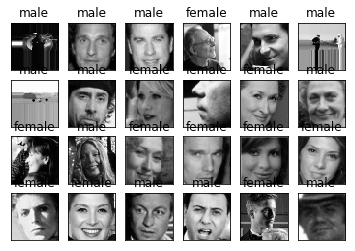

In [37]:
import matplotlib.pyplot as plt

# if you need to create the data:
# test_data = process_test_data()
test_data = np.load('Image_dataset/gender_test_data.npy') # if you already have some saved:

fig=plt.figure()

for label,data in enumerate(test_data[:24]):
    # female: [1,0]
    # male: [0,1]
    
    img_label = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,6,label+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 0: str_label='female'
    else: str_label='male'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [38]:
from tqdm import tqdm

with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 5000/5000 [00:24<00:00, 203.33it/s]
